In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

SVM Test Accuracy: 0.625
SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624




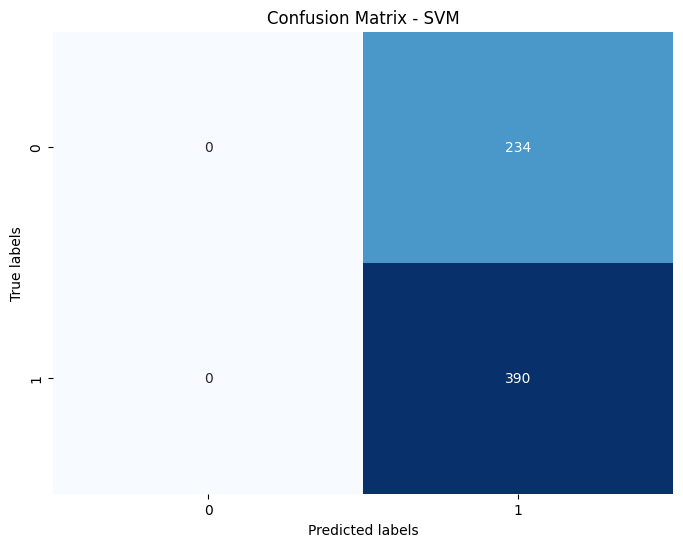

Random Forest Test Accuracy: 0.7115384615384616
Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.24      0.39       234
           1       0.69      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.82      0.62      0.60       624
weighted avg       0.79      0.71      0.65       624




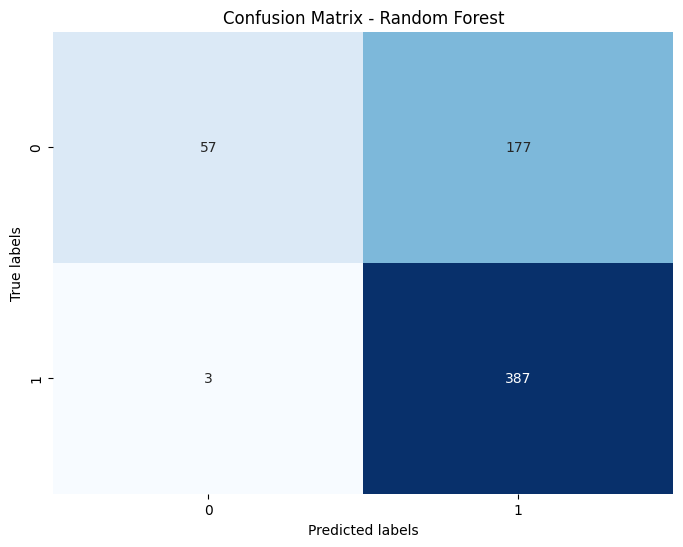

XGBoost Test Accuracy: 0.7660256410256411
XGBoost Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.41      0.57       234
           1       0.73      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.83      0.69      0.70       624
weighted avg       0.81      0.77      0.74       624




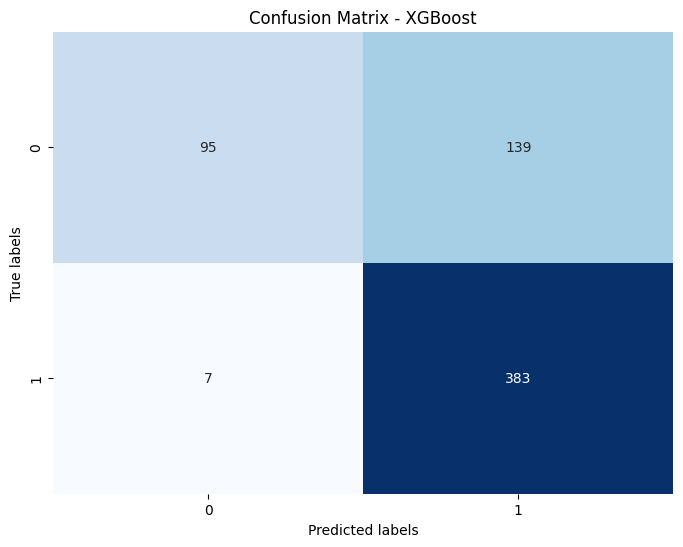

Voting Classifier Test Accuracy: 0.7067307692307693
Voting Classifier Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.22      0.36       234
           1       0.68      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.61      0.59       624
weighted avg       0.79      0.71      0.64       624




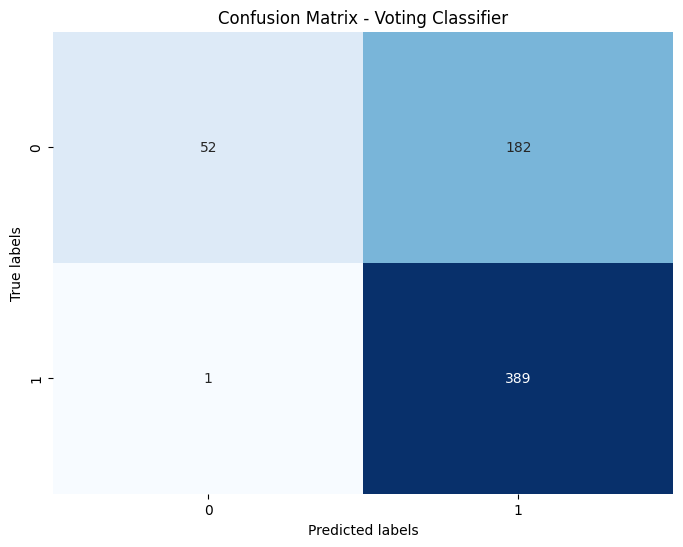

In [16]:
import os
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# Load the dataset and split into train, validation, and test sets
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

img_size = 224  # Assuming you want to resize the images to 224x224

def load_data(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            # Resize the image while maintaining its aspect ratio
            resized_image = image.resize((img_size, img_size))
            images.append(np.array(resized_image))
            labels.append(label)
    return images, labels

# Load and preprocess the data
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

# Convert lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Expand dimensions for grayscale images
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Choose the desired number of principal components
n_components = 75

# Apply PCA for feature extraction
pca = PCA(n_components=n_components)
X_train_features = pca.fit_transform(X_train_flat)
X_val_features = pca.transform(X_val_flat)
X_test_features = pca.transform(X_test_flat)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Initialize classifiers with best parameters
svc = SVC(kernel='rbf', gamma=1.0, C=1000.0, probability=True)
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, n_estimators=250, max_depth=3)

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[('svc', svc), ('rf', rf), ('xgb', xgb)], voting='hard')

# Iterate over each classifier
for clf_name, clf in [('SVM', svc), ('Random Forest', rf), ('XGBoost', xgb), ('Voting Classifier', voting_clf)]:
    # Train the classifier
    clf.fit(X_train_features, y_train)

    # Predictions on test set
    y_pred_test = clf.predict(X_test_features)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f'{clf_name} Test Accuracy: {accuracy_test}')
    
    # Confusion matrix for test set
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Classification report for test set
    test_classification_rep = classification_report(y_test, y_pred_test)
    print(f'{clf_name} Test Classification Report:\n{test_classification_rep}\n')
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {clf_name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

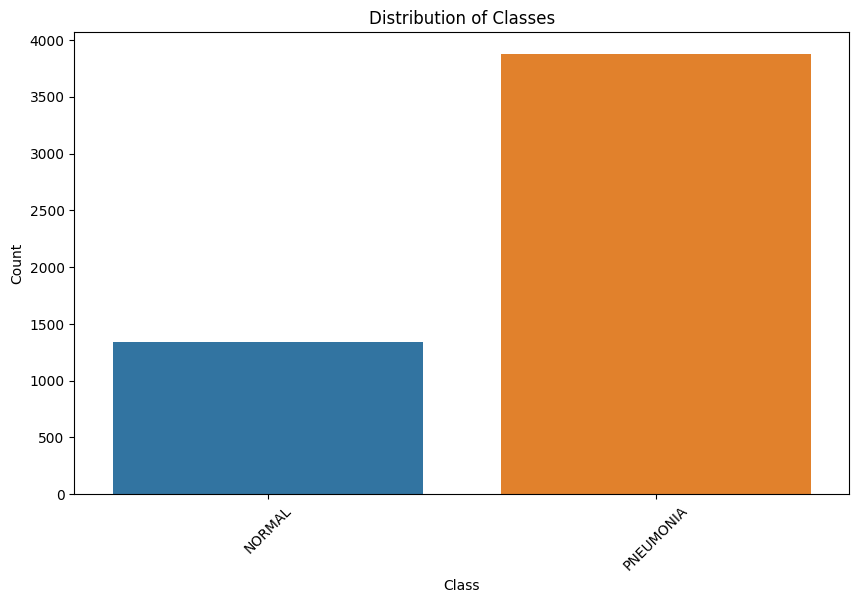

In [17]:
# Get the class labels
class_labels = le.classes_

# Count occurrences of each class in the training set
class_counts = np.bincount(y_train)

# Plot the classes
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
